In [1]:
import sys
sys.path.append("../script/")

import Functions
from Engine import Engine


from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import numpy as np
import pandas as pd
from time import time

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# data

In [3]:
# ref from 2segp github
# Classification dataset names - choose from following datasets 

CLASS_DATASET_NAMES = ['bcw','heart','iono','parks','sonar']
dataset_name = CLASS_DATASET_NAMES[1]


# Load the dataset
Xy = np.genfromtxt('test_data/'+dataset_name+'.csv', delimiter=',')
X = Xy[:, :-1]
y = Xy[:, -1]   # last column is the label

# simple operators

boost_num = 1000

seed = np.random.randint(9999999)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [4]:
df = pd.read_csv("../data/connect-4.tsv",delimiter='\t')
X = df.iloc[:,:-1].to_numpy().astype("float")
y = df.iloc[:,-1].to_numpy().astype("int")

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify=y)

# model

In [11]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p
    
def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for node in stack:
        grads = node.predict_grad(X)
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

In [12]:
train_acc = []
test_acc = []

stack = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

In [31]:
train_acc = []
test_acc = []

stack = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

learning_rate = 0.3
bins = 2
lam = 10
stack = []
losses = []
num_features = X_train.shape[1]

max_depth = 3
tolerance = 1e-4


total_size = 10
elite_size = 10

eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,learning_rate,bins,max_depth,lam)
origin_features = eg.nodes.copy()
origin_losses = eg.losses.copy()
stack.extend(eg.nodes)
losses.extend(origin_losses)

for i in range(100):
    for j in range(1):
        eg.evolve(total_size,elite_size,tolerance=tolerance,verbose=0)
    stack,losses = eg.adding_unique_node(stack,losses,eg.nodes[num_features:],tolerance=tolerance)
    eg.nodes = origin_features.copy()
    eg.losses = origin_losses.copy()
    print(len(stack),i)
    # if len(stack) > 8000:
    #         break

fits = [i.estimator.loss for i in stack]
a = [stack[i] for i in np.argsort(fits)]

log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)
previous_sse = np.sum(np.power(y_train_one_hot - p,2))
score = []

train_acc = []
test_acc = []

train_sse = []
test_sse = []


counts = []


for i,node in enumerate(a):
    node.estimator.lam = lam
    grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

    test_grads = node.predict_grad(X_test)
    test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)


    train_sse.append(np.sum(np.power(y_train_one_hot - p,2)))
    test_sse.append(np.sum(np.power(y_test_one_hot - test_p,2)))


    score.append(previous_sse - train_sse[-1])
    previous_sse = train_sse[-1]


    pred = np.argmax(p,axis=1)
    train_acc.append(accuracy_score(pred,y_train))
    test_pred = np.argmax(test_p,axis=1)
    test_acc.append(accuracy_score(test_pred,y_test))
print(train_sse[-1],test_sse[-1],i+1,len(a))
print('\t',train_acc[-1],test_acc[-1],i+1,len(a))

50 0
55 1
62 2
68 3
72 4
76 5
80 6
87 7
93 8
97 9
102 10
108 11
114 12
123 13
128 14
131 15
136 16
140 17
149 18
154 19
161 20
164 21
168 22
173 23
181 24
185 25
190 26
194 27
198 28
202 29
206 30
212 31
217 32
222 33
225 34
228 35
230 36
235 37
239 38
242 39
248 40
250 41
254 42
261 43
263 44
269 45
274 46
282 47
285 48
292 49
296 50
302 51
305 52
309 53
314 54
318 55
321 56
325 57
332 58
335 59
337 60
341 61
344 62
349 63
353 64
355 65
360 66
364 67
369 68
374 69
376 70
380 71
386 72
389 73
396 74
399 75
402 76
404 77
406 78
411 79
417 80
420 81
423 82
426 83
431 84
437 85
441 86
445 87
449 88
451 89
453 90
453 91
457 92
460 93
462 94
465 95
468 96
470 97
473 98
476 99
481 100
484 101
489 102
492 103
495 104
498 105
503 106
506 107
511 108
512 109
514 110
518 111
519 112
522 113
524 114
526 115
530 116
531 117
534 118
536 119
538 120
539 121
544 122
545 123
546 124
548 125
552 126
554 127
556 128
559 129
560 130
562 131
565 132
567 133
572 134
574 135
577 136
578 137
580 138
581 139


In [32]:
train_acc = []
test_acc = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

fits = [i.estimator.loss for i in stack]
a = [stack[i] for i in np.argsort(fits)]

for _ in range(100):

    for i,node in enumerate(a):
        # node.estimator.lam = 10
        grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

        test_grads = node.predict_grad(X_test)
        test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)



        pred = np.argmax(p,axis=1)
        train_acc.append(accuracy_score(pred,y_train))
        test_pred = np.argmax(test_p,axis=1)
        test_acc.append(accuracy_score(test_pred,y_test))
    
    print(train_acc[-1],test_acc[-1])

0.7926164959441057 0.7891885490985524
0.8062940375392267 0.7997868498179342
0.8133992539522766 0.8048787708339501
0.8186097459885132 0.8095266289706623
0.8228728758363432 0.8125166523579739
0.8260110130854402 0.814411320643003
0.8283794185564569 0.816246780544125
0.8303037480016578 0.8179934278693863
0.831606371010717 0.8187631368601794
0.8328497838830008 0.8196216584268332
0.833945171413346 0.8203321590337191
0.8350405589436911 0.8209834512566979


In [27]:
sum([n.numNode for n in stack])

15439

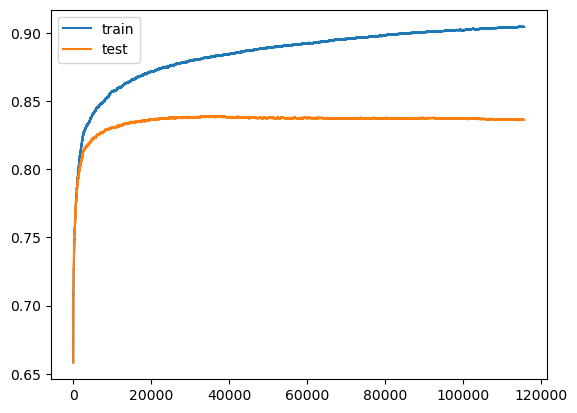

In [28]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(["train","test"])

# Decision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

print(classification_report(y_train,clf.predict(X_train)))
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3225
           1       1.00      1.00      1.00      8317
           2       1.00      1.00      1.00     22236

    accuracy                           1.00     33778
   macro avg       1.00      1.00      1.00     33778
weighted avg       1.00      1.00      1.00     33778

              precision    recall  f1-score   support

           0       0.23      0.24      0.23      3224
           1       0.61      0.61      0.61      8318
           2       0.83      0.83      0.83     22237

    accuracy                           0.72     33779
   macro avg       0.56      0.56      0.56     33779
weighted avg       0.72      0.72      0.72     33779



# XGBoost

In [51]:
import xgboost


In [68]:
xgb = xgboost.XGBClassifier(n_estimators = 150,max_depth = 6)
xgb.fit(X_train,y_train)

print(classification_report(y_train,xgb.predict(X_train),digits=5))
print(classification_report(y_test,xgb.predict(X_test),digits=5))

import json

def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    depths = list(item_generator(json_input, 'depth'))
    return max(depths) + 1 if len(depths) != 0 else 1


booster = xgb.get_booster()

tree_df = booster.trees_to_dataframe()
depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
len(depths),np.average(depths),len(tree_df)

              precision    recall  f1-score   support

           0    0.84894   0.33457   0.47998      3225
           1    0.85475   0.87664   0.86555      8317
           2    0.90028   0.97077   0.93420     22236

    accuracy                        0.88685     33778
   macro avg    0.86799   0.72733   0.75991     33778
weighted avg    0.88417   0.88685   0.87393     33778

              precision    recall  f1-score   support

           0    0.53552   0.18238   0.27210      3224
           1    0.77969   0.78288   0.78128      8318
           2    0.86847   0.95017   0.90749     22237

    accuracy                        0.83570     33779
   macro avg    0.72789   0.63848   0.65362     33779
weighted avg    0.81483   0.83570   0.81577     33779



(450, 6.0, 41222)